# Imports

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
# Used to customize the axis labels by addding percentage symbols.
import matplotlib.ticker as mtick
# Used to customize date formats, like displaying the month under the year to save space.
import matplotlib.dates as mdates
# TODO: Seaborn is only used for the heatmap, just use matplotlib one?
import seaborn as sns
import numpy as np
# Only used for type hints.
import datetime
# Used for floor and ceil when rounding the ends of temperature ranges to nearest 5C.
import math
from sklearn import linear_model, metrics
from sklearn.preprocessing import PolynomialFeatures

# Settings and parameters

In [72]:
plt.rcParams["font.size"] = 12
# TODO: Try to figure out the screen size of the user and set the size based on that.
plt.rcParams["figure.figsize"] = [20, 12] 
#plt.rcParams["figure.constrained_layout.use"] = True
plt.rcParams["axes.xmargin"] = 0
plt.rcParams["axes.ymargin"] = 0
#plt.rcParams["axes.autolimit_mode"] = "round_numbers"

csv_directory = "Dataset/"
filename = "helsinki_kaukolampo.csv"



# Prevent wrapping of cell contents when displaying dataframes.

In [73]:
<!-- This causes the tables to display a scrollbar if they are too wide for the screen. 
     TODO: Check if this is needed and/or works with GitHub .md file. -->
%%html
<style>
.dataframe td {
    white-space: nowrap;
}
</style>

# Load the district heating energy consumption data to a dataframe.

In [74]:
df_district_heating = pd.read_csv(csv_directory + filename, delimiter = ";", decimal = ",")
df_district_heating

,date_time,dh_MWh
0,01.01.2015 00:00,924.200000
1,01.01.2015 01:00,926.300000
2,01.01.2015 02:00,942.100000
3,01.01.2015 03:00,957.100000
4,01.01.2015 04:00,972.200000
...,...,...
61387,01.01.2022 19:00,1632.531476
61388,01.01.2022 20:00,1602.483984
61389,01.01.2022 21:00,1579.049687
61390,01.01.2022 22:00,1561.765870


In [75]:
print(df_district_heating.dtypes)

date_time     object
dh_MWh       float64
dtype: object


In [76]:
# Convert the datetime column to the type of datetime instead of object.
df_district_heating.date_time = pd.to_datetime(df_district_heating.date_time, format = "%d.%m.%Y %H:%M")
# Change the datetime column the be the index and drop the original column.
#df_district_heating.index = df_district_heating.date_time
#df_district_heating.drop(columns = "date_time", inplace = True)

print(df_district_heating.dtypes)
df_district_heating

date_time    datetime64[ns]
dh_MWh              float64
dtype: object


,date_time,dh_MWh
0,2015-01-01 00:00:00,924.200000
1,2015-01-01 01:00:00,926.300000
2,2015-01-01 02:00:00,942.100000
3,2015-01-01 03:00:00,957.100000
4,2015-01-01 04:00:00,972.200000
...,...,...
61387,2022-01-01 19:00:00,1632.531476
61388,2022-01-01 20:00:00,1602.483984
61389,2022-01-01 21:00:00,1579.049687
61390,2022-01-01 22:00:00,1561.765870


In [77]:
# Finnish Meteoroligal Institute restricted downloading all the data on a single search,
# so we have to concatenate yearly files.
df_weather_2020 = pd.read_csv(csv_directory + "helsinki_saa_kaisaniemi_2020.csv") 
df_weather_2021 = pd.read_csv(csv_directory + "helsinki_saa_kaisaniemi_2021.csv") 
df_weather_2022 = pd.read_csv(csv_directory + "helsinki_saa_kaisaniemi_2022.csv") 
df_weather = pd.concat([df_weather_2020, df_weather_2021, df_weather_2022])
df_weather

,Vuosi,Kk,Pv,Klo,Aikavyöhyke,Pilvien määrä (1/8),Ilmanpaine (msl) (hPa),Sademäärä (mm),Suhteellinen kosteus (%),Sateen intensiteetti (mm/h),Lumensyvyys (cm),Ilman lämpötila (degC),Kastepistelämpötila (degC),Näkyvyys (m),Tuulen suunta (deg),Puuskanopeus (m/s),Tuulen nopeus (m/s)
0,2020,1,1,00:00,UTC,0.0,1011.6,0.0,85.0,0.0,0.0,-0.2,-2.4,34620.0,265.0,4.6,3.2
1,2020,1,1,01:00,UTC,0.0,1011.4,0.0,84.0,0.0,0.0,0.2,-2.2,47810.0,275.0,5.6,3.7
2,2020,1,1,02:00,UTC,0.0,1011.1,0.0,83.0,0.0,0.0,0.4,-2.2,42910.0,284.0,6.6,4.7
3,2020,1,1,03:00,UTC,1.0,1010.8,0.0,82.0,0.0,0.0,0.7,-2.1,42960.0,286.0,6.1,4.0
4,2020,1,1,04:00,UTC,1.0,1010.2,0.0,82.0,0.0,0.0,0.8,-1.9,50000.0,263.0,5.6,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4844,2022,7,21,20:00,UTC,0.0,1015.6,0.0,76.0,0.0,-1.0,19.2,14.9,49690.0,182.0,2.2,1.0
4845,2022,7,21,21:00,UTC,0.0,1015.6,0.0,70.0,0.0,-1.0,19.4,13.8,49430.0,188.0,2.9,1.7
4846,2022,7,21,22:00,UTC,0.0,1015.6,0.0,77.0,0.0,-1.0,18.0,14.0,50000.0,185.0,2.6,1.2
4847,2022,7,21,23:00,UTC,0.0,1015.3,0.0,78.0,0.0,-1.0,18.2,14.3,50000.0,179.0,2.5,1.5


In [78]:
# Convert Vuosi, Kk, Pv, Klo to datetime.

# The columns HAVE TO be renamed to english year, etc. or their plural versions for to_datetime to work.
df_weather.rename(columns = {"Vuosi":"year", "Kk":"month", "Pv":"day"}, inplace = True)
# Since the time in Klo column is in form of hour:minute, slice the relevant parts to their own columns.
df_weather["hour"] = df_weather.Klo.str[:2]
df_weather["minute"] = df_weather.Klo.str[3:]

# Create a new datetime column from the relevant columns.
df_weather["date_time"] = pd.to_datetime(df_weather[["day", "month", "year", "hour", "minute"]])

# Change the index to be the datetime column.
#df_weather.index = df_weather.date_time

# Drop the now unneeded columns.
df_weather.drop(columns = ["year", "month", "day", "hour", "minute", "Klo", "Aikavyöhyke"], 
                inplace = True)

df_weather

,Pilvien määrä (1/8),Ilmanpaine (msl) (hPa),Sademäärä (mm),Suhteellinen kosteus (%),Sateen intensiteetti (mm/h),Lumensyvyys (cm),Ilman lämpötila (degC),Kastepistelämpötila (degC),Näkyvyys (m),Tuulen suunta (deg),Puuskanopeus (m/s),Tuulen nopeus (m/s),date_time
0,0.0,1011.6,0.0,85.0,0.0,0.0,-0.2,-2.4,34620.0,265.0,4.6,3.2,2020-01-01 00:00:00
1,0.0,1011.4,0.0,84.0,0.0,0.0,0.2,-2.2,47810.0,275.0,5.6,3.7,2020-01-01 01:00:00
2,0.0,1011.1,0.0,83.0,0.0,0.0,0.4,-2.2,42910.0,284.0,6.6,4.7,2020-01-01 02:00:00
3,1.0,1010.8,0.0,82.0,0.0,0.0,0.7,-2.1,42960.0,286.0,6.1,4.0,2020-01-01 03:00:00
4,1.0,1010.2,0.0,82.0,0.0,0.0,0.8,-1.9,50000.0,263.0,5.6,3.8,2020-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4844,0.0,1015.6,0.0,76.0,0.0,-1.0,19.2,14.9,49690.0,182.0,2.2,1.0,2022-07-21 20:00:00
4845,0.0,1015.6,0.0,70.0,0.0,-1.0,19.4,13.8,49430.0,188.0,2.9,1.7,2022-07-21 21:00:00
4846,0.0,1015.6,0.0,77.0,0.0,-1.0,18.0,14.0,50000.0,185.0,2.6,1.2,2022-07-21 22:00:00
4847,0.0,1015.3,0.0,78.0,0.0,-1.0,18.2,14.3,50000.0,179.0,2.5,1.5,2022-07-21 23:00:00


In [79]:
print(df_weather.dtypes)

Pilvien määrä (1/8)                   float64
Ilmanpaine (msl) (hPa)                float64
Sademäärä (mm)                        float64
Suhteellinen kosteus (%)              float64
Sateen intensiteetti (mm/h)           float64
Lumensyvyys (cm)                      float64
Ilman lämpötila (degC)                float64
Kastepistelämpötila (degC)            float64
Näkyvyys (m)                          float64
Tuulen suunta (deg)                   float64
Puuskanopeus (m/s)                    float64
Tuulen nopeus (m/s)                   float64
date_time                      datetime64[ns]
dtype: object


In [80]:
# Get the start date of the weather data.
#start_datetime: datetime = df_weather.index[0]
#end_datetime: datetime = df_district_heating.index[-1]
start_datetime: datetime = df_weather.date_time.iloc[0]
end_datetime: datetime = df_district_heating.date_time.iloc[-1]
start_date: datetime.date = start_datetime.date()
end_date: datetime.date = end_datetime.date()
start_datetime, end_datetime, start_date, end_date

C:\Users\jussi\AppData\Local\Temp\ipykernel_304\210752612.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start_datetime: pd.datetime = df_weather.date_time.iloc[0]
C:\Users\jussi\AppData\Local\Temp\ipykernel_304\210752612.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end_datetime: pd.datetime = df_district_heating.date_time.iloc[-1]
C:\Users\jussi\AppData\Local\Temp\ipykernel_304\210752612.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start_date: pd.datetime.date = start_datetime.date()
C:\Users\jussi\AppData\Local\Temp\ipykernel_304\210752612.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from date

(Timestamp('2020-01-01 00:00:00'),
 Timestamp('2022-01-01 23:00:00'),
 datetime.date(2020, 1, 1),
 datetime.date(2022, 1, 1))

In [81]:
# Cut the start of district heating dataframe to the start of weather dataframe (1.1.2020 00:00).
df_district_heating = df_district_heating[df_district_heating.date_time >= start_datetime]
df_district_heating

,date_time,dh_MWh
43824,2020-01-01 00:00:00,1164.031059
43825,2020-01-01 01:00:00,1148.636120
43826,2020-01-01 02:00:00,1121.186005
43827,2020-01-01 03:00:00,1119.677224
43828,2020-01-01 04:00:00,1142.770020
...,...,...
61387,2022-01-01 19:00:00,1632.531476
61388,2022-01-01 20:00:00,1602.483984
61389,2022-01-01 21:00:00,1579.049687
61390,2022-01-01 22:00:00,1561.765870


In [82]:
# Cut the end of the weather data to end date of district heating dataframe (2022-01-01 23:00:00).
df_weather = df_weather[df_weather.date_time <= end_datetime]
df_weather

,Pilvien määrä (1/8),Ilmanpaine (msl) (hPa),Sademäärä (mm),Suhteellinen kosteus (%),Sateen intensiteetti (mm/h),Lumensyvyys (cm),Ilman lämpötila (degC),Kastepistelämpötila (degC),Näkyvyys (m),Tuulen suunta (deg),Puuskanopeus (m/s),Tuulen nopeus (m/s),date_time
0,0.0,1011.6,0.0,85.0,0.0,0.0,-0.2,-2.4,34620.0,265.0,4.6,3.2,2020-01-01 00:00:00
1,0.0,1011.4,0.0,84.0,0.0,0.0,0.2,-2.2,47810.0,275.0,5.6,3.7,2020-01-01 01:00:00
2,0.0,1011.1,0.0,83.0,0.0,0.0,0.4,-2.2,42910.0,284.0,6.6,4.7,2020-01-01 02:00:00
3,1.0,1010.8,0.0,82.0,0.0,0.0,0.7,-2.1,42960.0,286.0,6.1,4.0,2020-01-01 03:00:00
4,1.0,1010.2,0.0,82.0,0.0,0.0,0.8,-1.9,50000.0,263.0,5.6,3.8,2020-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,0.0,1020.0,0.0,91.0,0.0,6.0,-8.1,-9.3,50000.0,309.0,5.9,4.0,2022-01-01 19:00:00
20,0.0,1020.2,0.0,90.0,0.0,6.0,-8.8,-10.1,50000.0,321.0,5.8,4.1,2022-01-01 20:00:00
21,0.0,1020.7,0.0,89.0,0.0,6.0,-9.0,-10.4,50000.0,315.0,4.4,3.1,2022-01-01 21:00:00
22,1.0,1020.1,0.0,90.0,0.0,6.0,-9.1,-10.5,47250.0,313.0,5.0,3.5,2022-01-01 22:00:00


In [83]:
# Combine the data from both dataframes to new dataframe.
# The district heating data is per hour, and we also requested the weather data per hour,
# so the dataframes should be of exact size with the same times.
df_district_weather_exact = pd.merge(df_district_heating, df_weather)#, left_index = True, right_index = True)
df_district_weather_exact

,date_time,dh_MWh,Pilvien määrä (1/8),Ilmanpaine (msl) (hPa),Sademäärä (mm),Suhteellinen kosteus (%),Sateen intensiteetti (mm/h),Lumensyvyys (cm),Ilman lämpötila (degC),Kastepistelämpötila (degC),Näkyvyys (m),Tuulen suunta (deg),Puuskanopeus (m/s),Tuulen nopeus (m/s)
0,2020-01-01 00:00:00,1164.031059,0.0,1011.6,0.0,85.0,0.0,0.0,-0.2,-2.4,34620.0,265.0,4.6,3.2
1,2020-01-01 01:00:00,1148.636120,0.0,1011.4,0.0,84.0,0.0,0.0,0.2,-2.2,47810.0,275.0,5.6,3.7
2,2020-01-01 02:00:00,1121.186005,0.0,1011.1,0.0,83.0,0.0,0.0,0.4,-2.2,42910.0,284.0,6.6,4.7
3,2020-01-01 03:00:00,1119.677224,1.0,1010.8,0.0,82.0,0.0,0.0,0.7,-2.1,42960.0,286.0,6.1,4.0
4,2020-01-01 04:00:00,1142.770020,1.0,1010.2,0.0,82.0,0.0,0.0,0.8,-1.9,50000.0,263.0,5.6,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17565,2022-01-01 19:00:00,1632.531476,0.0,1020.0,0.0,91.0,0.0,6.0,-8.1,-9.3,50000.0,309.0,5.9,4.0
17566,2022-01-01 20:00:00,1602.483984,0.0,1020.2,0.0,90.0,0.0,6.0,-8.8,-10.1,50000.0,321.0,5.8,4.1
17567,2022-01-01 21:00:00,1579.049687,0.0,1020.7,0.0,89.0,0.0,6.0,-9.0,-10.4,50000.0,315.0,4.4,3.1
17568,2022-01-01 22:00:00,1561.765870,1.0,1020.1,0.0,90.0,0.0,6.0,-9.1,-10.5,47250.0,313.0,5.0,3.5


# Convert column names to english and remove any spaces and special characters.

In [84]:
# TODO: If downloaded from the english version of the finnish meteorological institute
# web page, the column names will be in english. Will still have to remove spaces though.
df_district_weather_exact = df_district_weather_exact.rename(columns = {
                                            "dh_MWh": "district_heating_MWh", 
                                            "Pilvien määrä (1/8)": "cloud_coverage_1_8",
                                            "Ilmanpaine (msl) (hPa)": "air_pressure_msl_hPa",
                                            "Sademäärä (mm)": "rain_amount_mm",
                                            "Suhteellinen kosteus (%)": "relative_humidity",
                                            "Sateen intensiteetti (mm/h)": "rain_intensity_mm_h",
                                            "Lumensyvyys (cm)": "snow_depth_cm",
                                            "Ilman lämpötila (degC)": "air_temperature_C",
                                            "Kastepistelämpötila (degC)": "dew_point_temp_C",
                                            "Näkyvyys (m)": "visibility_m",
                                            "Tuulen suunta (deg)": "wind_direction_deg",
                                            "Puuskanopeus (m/s)": "gust_speed_m_s",
                                            "Tuulen nopeus (m/s)": "wind_speed_m_s"})

# Convert some float columns to integers. Int64 is a numpy datatype that supports NaN.
df_district_weather_exact.cloud_coverage_1_8 = df_district_weather_exact.cloud_coverage_1_8.astype("Int64")
df_district_weather_exact.relative_humidity = df_district_weather_exact.relative_humidity.astype("Int64")
df_district_weather_exact.snow_depth_cm = df_district_weather_exact.snow_depth_cm.astype("Int64")
df_district_weather_exact.visibility_m = df_district_weather_exact.visibility_m.astype("Int64")
df_district_weather_exact.wind_direction_deg = df_district_weather_exact.wind_direction_deg.astype("Int64")

df_district_weather_exact

,date_time,district_heating_MWh,cloud_coverage_1_8,air_pressure_msl_hPa,rain_amount_mm,relative_humidity,rain_intensity_mm_h,snow_depth_cm,air_temperature_C,dew_point_temp_C,visibility_m,wind_direction_deg,gust_speed_m_s,wind_speed_m_s
0,2020-01-01 00:00:00,1164.031059,0,1011.6,0.0,85,0.0,0,-0.2,-2.4,34620,265,4.6,3.2
1,2020-01-01 01:00:00,1148.636120,0,1011.4,0.0,84,0.0,0,0.2,-2.2,47810,275,5.6,3.7
2,2020-01-01 02:00:00,1121.186005,0,1011.1,0.0,83,0.0,0,0.4,-2.2,42910,284,6.6,4.7
3,2020-01-01 03:00:00,1119.677224,1,1010.8,0.0,82,0.0,0,0.7,-2.1,42960,286,6.1,4.0
4,2020-01-01 04:00:00,1142.770020,1,1010.2,0.0,82,0.0,0,0.8,-1.9,50000,263,5.6,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17565,2022-01-01 19:00:00,1632.531476,0,1020.0,0.0,91,0.0,6,-8.1,-9.3,50000,309,5.9,4.0
17566,2022-01-01 20:00:00,1602.483984,0,1020.2,0.0,90,0.0,6,-8.8,-10.1,50000,321,5.8,4.1
17567,2022-01-01 21:00:00,1579.049687,0,1020.7,0.0,89,0.0,6,-9.0,-10.4,50000,315,4.4,3.1
17568,2022-01-01 22:00:00,1561.765870,1,1020.1,0.0,90,0.0,6,-9.1,-10.5,47250,313,5.0,3.5


In [85]:
print(df_district_weather_exact.dtypes)

date_time               datetime64[ns]
district_heating_MWh           float64
cloud_coverage_1_8               Int64
air_pressure_msl_hPa           float64
rain_amount_mm                 float64
relative_humidity                Int64
rain_intensity_mm_h            float64
snow_depth_cm                    Int64
air_temperature_C              float64
dew_point_temp_C               float64
visibility_m                     Int64
wind_direction_deg               Int64
gust_speed_m_s                 float64
wind_speed_m_s                 float64
dtype: object


In [86]:
# Drop rows with NaNs at district_heating_MWh or air_temperature_C columns.
count_before_dropna = len(df_district_weather_exact)
df_district_weather_exact = df_district_weather_exact.dropna(subset = ["district_heating_MWh", "air_temperature_C"])
count_dropped_rows = count_before_dropna - len(df_district_weather_exact)
print(f"Dropped rows: {count_dropped_rows}")

Dropped rows: 20


# Write the new dataframe to a new file.

In [87]:
#df_district_weather_exact.to_csv("HELDisctrictTemp.csv")

<AxesSubplot:>

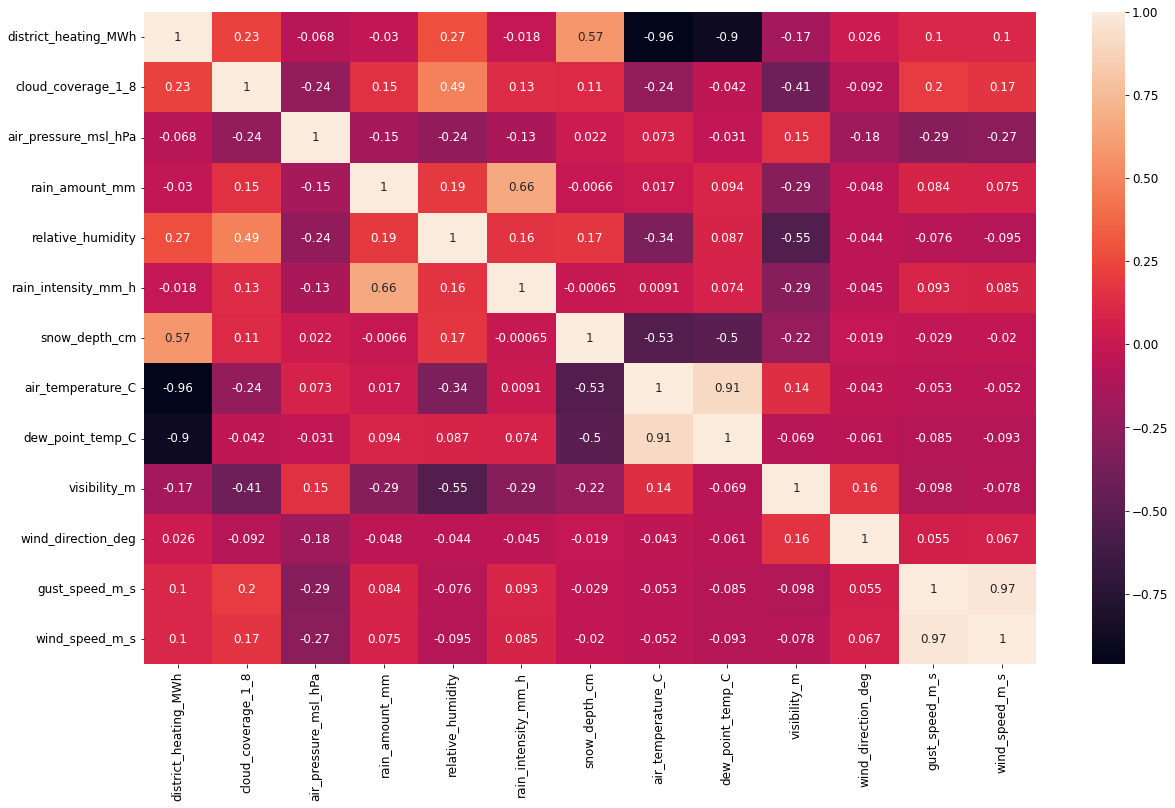

In [88]:
corr = df_district_weather_exact.corr()
sns.heatmap(corr, annot = True, xticklabels = corr.columns, yticklabels = corr.columns)

In [89]:
# Show top and bottom 5 correlated values for the dataframe. 
# Unstack the values to a Series (list) instead of a dataframe, 
# then drop duplicate correlations, then sort by largest to smallest by absolute values.
corr_list = corr.unstack().drop_duplicates().sort_values(key = abs, ascending = False)
# Drop the first element, which is MWh correlation with itself, which is 1.
corr_list.drop(corr_list.index[0], inplace = True)
# Get the inversely correlated values on descending order.
#corr_list_reversed = corr.unstack().drop_duplicates().sort_values(kind = "quicksort")
corr_list.head(10)#, corr_list_reversed.head(10)

gust_speed_m_s        wind_speed_m_s         0.969329
district_heating_MWh  air_temperature_C     -0.963080
air_temperature_C     dew_point_temp_C       0.906850
district_heating_MWh  dew_point_temp_C      -0.899612
rain_amount_mm        rain_intensity_mm_h    0.661846
district_heating_MWh  snow_depth_cm          0.571958
relative_humidity     visibility_m          -0.548600
snow_depth_cm         air_temperature_C     -0.534771
                      dew_point_temp_C      -0.497188
cloud_coverage_1_8    relative_humidity      0.486032
dtype: float64

In [90]:
# Correlation of district_heating_MWh column (district heating power consumption) with all other columns.
# [dh_MWh] selects just the comparisons of that column and [1:] drops comparison to first column (itself).
df_district_weather_exact.corr()["district_heating_MWh"].sort_values(key = abs, ascending = False)

district_heating_MWh    1.000000
air_temperature_C      -0.963080
dew_point_temp_C       -0.899612
snow_depth_cm           0.571958
relative_humidity       0.272745
cloud_coverage_1_8      0.230964
visibility_m           -0.167457
wind_speed_m_s          0.100494
gust_speed_m_s          0.099560
air_pressure_msl_hPa   -0.067861
rain_amount_mm         -0.029846
wind_direction_deg      0.025628
rain_intensity_mm_h    -0.018482
Name: district_heating_MWh, dtype: float64

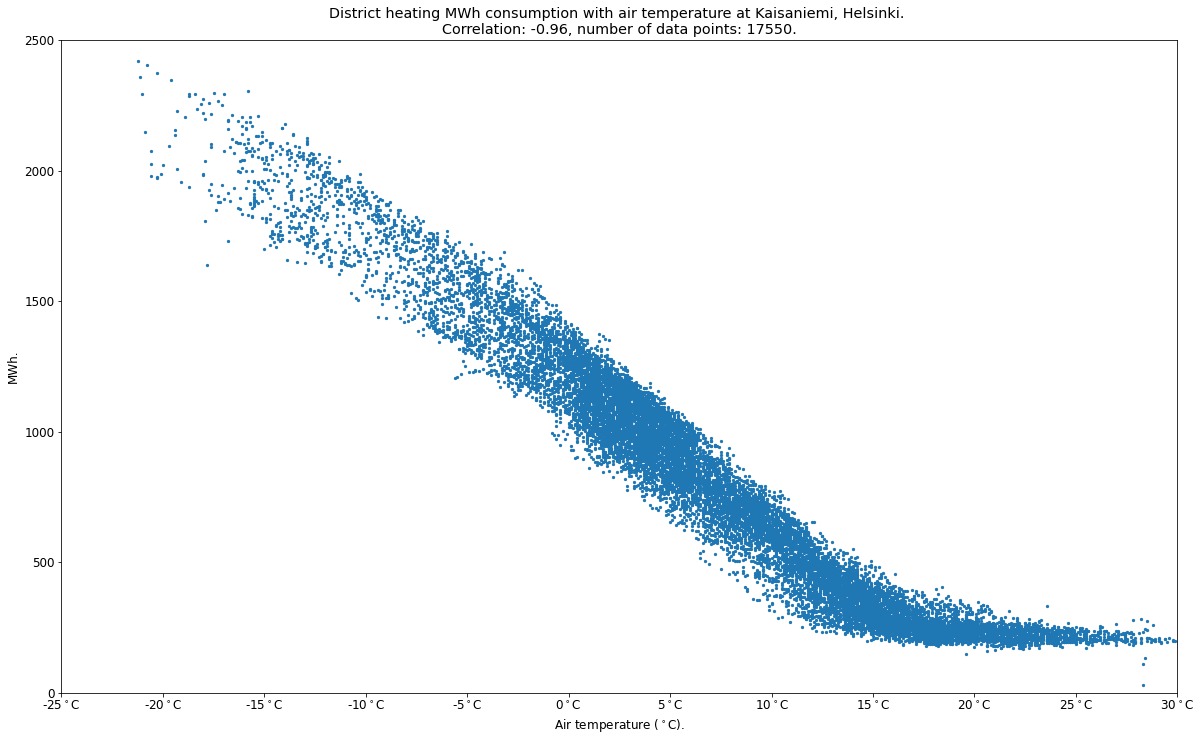

In [91]:
# Correlation of dh_MWh column (district heating power consumption) with the air temperature.
corr_MWh_temperature = round(df_district_weather_exact.corr()["district_heating_MWh"]["air_temperature_C"], 2)
number_of_data = len(df_district_weather_exact)

# Lowest and largest temperatures, rounded down and up respectively to nearest 5 degrees C.
min_temp = math.floor(df_district_weather_exact.air_temperature_C.min() / 5.0) * 5
max_temp = math.ceil(df_district_weather_exact.air_temperature_C.max() / 5.0) * 5
# Max consumption of district heating energy, rounded up to nearest 100 MWh.
max_consumption = math.ceil(df_district_weather_exact.district_heating_MWh.max() / 100.0) * 100



fig, axes = plt.subplots()

axes.set_title(f"""District heating MWh consumption with air temperature at Kaisaniemi, Helsinki. 
Correlation: {corr_MWh_temperature}, number of data points: {number_of_data}.""")

# Weird way to print Centigrade degree symbol.
axes.set_xlabel("Air temperature ($^\circ$C).")
plt.xlim(min_temp, max_temp)
plt.xticks(np.arange(min_temp, max_temp + 5, step = 5))
# Add degree symbol to all x-axis values.
axes.xaxis.set_major_formatter("{x}$^\circ$C")

axes.set_ylabel("MWh.")
axes.set_ylim(0, max_consumption)

axes.scatter(df_district_weather_exact.air_temperature_C, df_district_weather_exact.district_heating_MWh, s = 5)

plt.show()

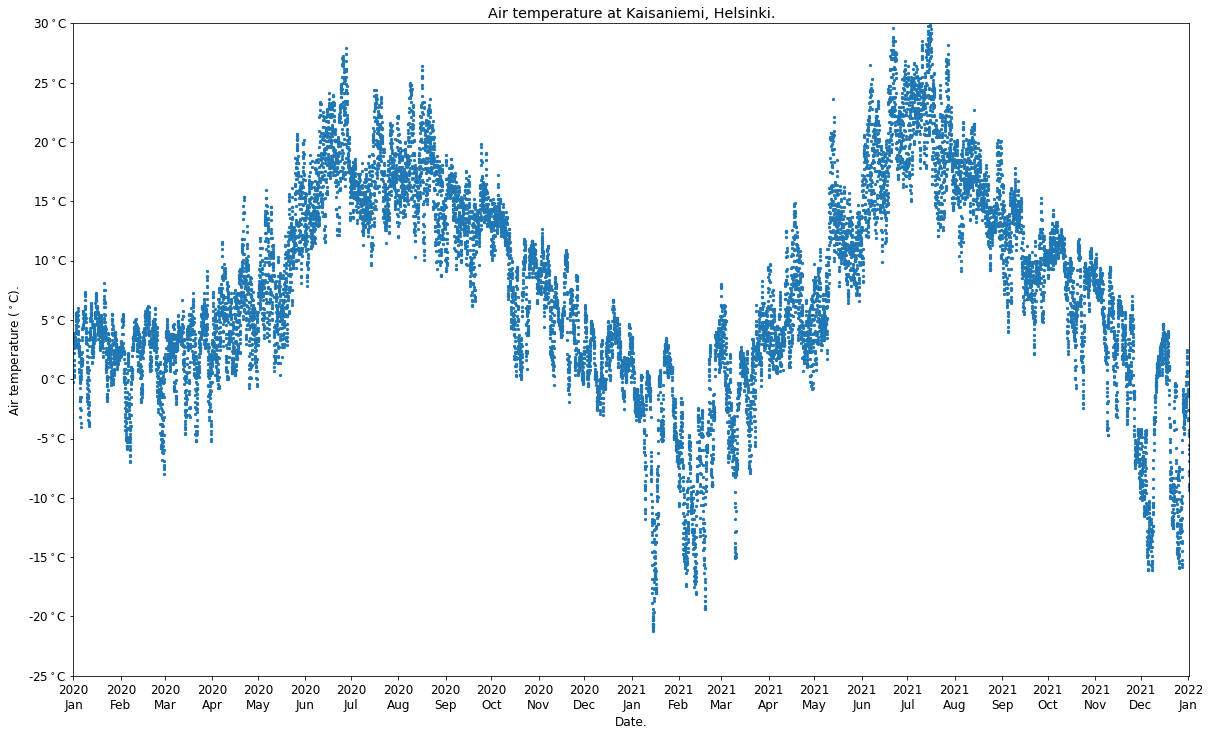

In [92]:
fig, axes = plt.subplots()

axes.set_title("Air temperature at Kaisaniemi, Helsinki.")
              
axes.set_xlabel("Date.")
# Drop month to second line in an abbreviated form, instead of same line with number form.
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y\n%b'))
# Show every month.
axes.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))

axes.set_ylabel("Air temperature ($^\circ$C).")
axes.set_ylim(min_temp, max_temp)
axes.set_yticks(np.arange(min_temp, max_temp + 5, step = 5))
# Add degree symbol to all y-axis values.
axes.yaxis.set_major_formatter("{x}$^\circ$C")

axes.scatter(df_district_weather_exact.date_time, df_district_weather_exact.air_temperature_C, s = 5)

#fig.savefig("HelsinkiEnergiaLampotilaAirtemp.png", facecolor = "white", transparent = False)

plt.show()

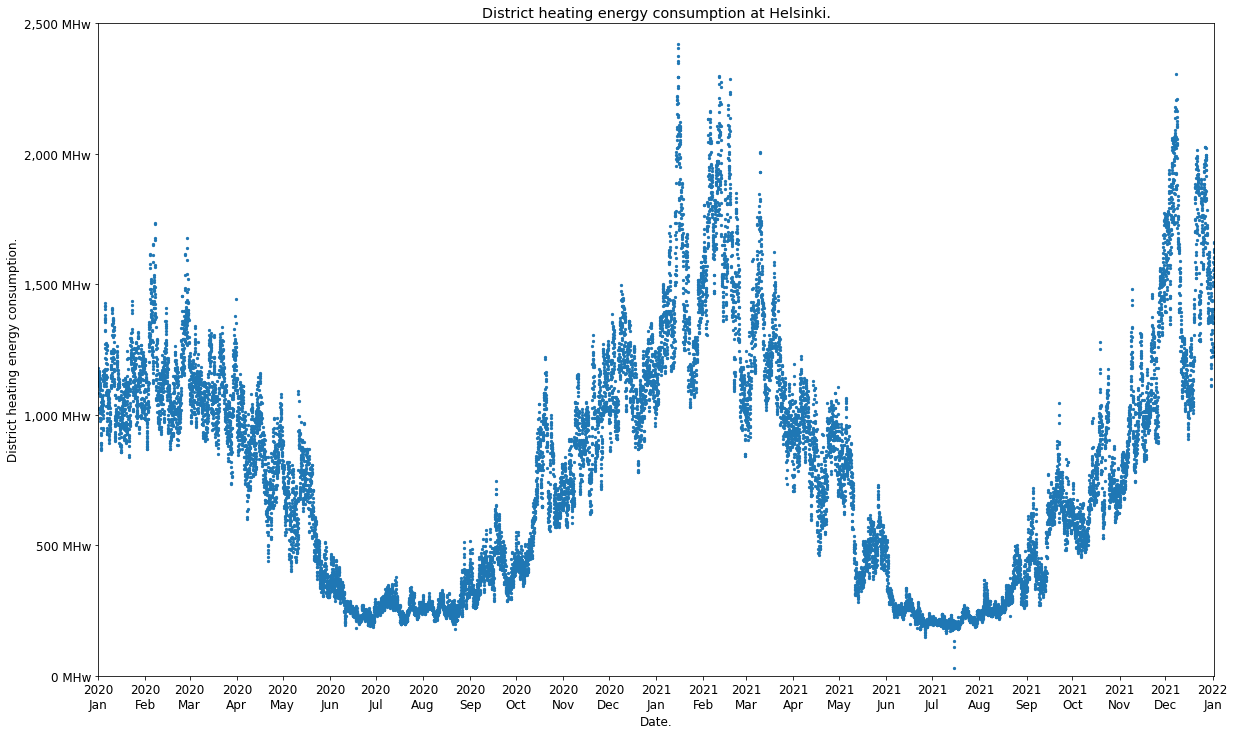

In [93]:
fig, axes = plt.subplots()

axes.set_title("District heating energy consumption at Helsinki.")

axes.set_xlabel("Date.")
# Drop month to second line in an abbreviated form, instead of same line with number form.
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y\n%b'))
# Show every month.
axes.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))

axes.set_ylabel("MHw.")
axes.set_ylim(0, max_consumption)
axes.set_ylabel("District heating energy consumption.")
axes.yaxis.set_major_formatter("{x:,.0f} MHw")



axes.scatter(df_district_weather_exact.date_time, df_district_weather_exact.district_heating_MWh, s = 5)

#fig.savefig("HelsinkiEnergiaLampotilaHeating.png", facecolor = "white", transparent = False)

plt.show()

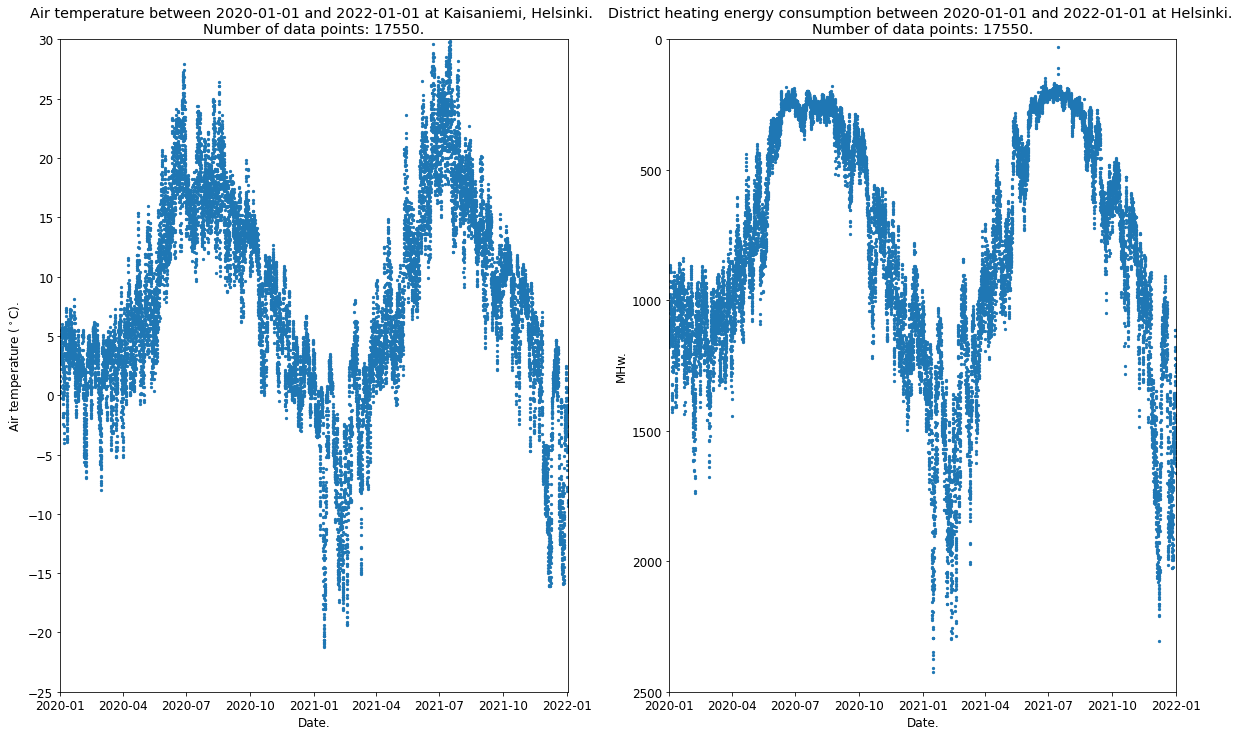

In [94]:
plt.subplot(1, 2, 1)
plt.title(f"""Air temperature between {start_date} and {end_date} at Kaisaniemi, Helsinki. 
Number of data points: {number_of_data}.""")
              
plt.xlabel("Date.")
plt.ylabel("Air temperature ($^\circ$C).")

plt.ylim(min_temp, max_temp)
plt.yticks(np.arange(min_temp, max_temp + 5, step = 5))

plt.scatter(df_district_weather_exact.date_time, df_district_weather_exact.air_temperature_C, s = 5)



plt.subplot(1, 2, 2)
plt.title(f"""District heating energy consumption between {start_date} and {end_date} at Helsinki. 
Number of data points: {number_of_data}.""")

plt.xlabel("Date.")
plt.ylabel("MHw.")

# Flip the energy consumption y-axis.
plt.ylim(max_consumption, 0)
plt.scatter(df_district_weather_exact.date_time, df_district_weather_exact.district_heating_MWh, s = 5)

plt.show()

In [95]:
def convert_column_percentages(column: pd.Series, fullpercentage: bool = True, reverse: bool = False) -> pd.Series:
    """Function for converting a numerical Pandas Series (column) to percentage values (0-100 or 0-1)
    proportional to the range of values in the original Series.

    For example: Temperatures in column range from -20 tot +20, 
    temperature of 0 is converted 50%, +20 to 100%.

    Args:
        column (pd.Series): Values to be converted to percentages.

        fullpercentage (bool, optional): Whether you want the values as 
        full percertages as values between 0-100 instead of multipliers between 0-1.

        reverse (bool, optional): Whether you want to reverse the values in the column.

    Returns:
        pd.Series: Pandas Series (column) with converted values between 0-100. \n

        None if some kind of error is encountered.
    """

    # Check that the column has numerical values.
    if not pd.api.types.is_numeric_dtype(column):
        return None
    
    converted_column: pd.Series = column

    # Check for any null values and replace them with average value.
    if converted_column.isnull().values.any():
        converted_column.fillna(column.mean(), inplace = True)
    
    # Get the highest and lowest values in the column.
    series_max = column.max()
    series_min = column.min()

    # Change the column values to be percentages proportional to the range of values.
    # For example: Temperatures range from -20 tot +20, temperature of 0 is 50%, +20 is 100%.
    # (original value - minimum) / (maximum - minimum)
    converted_column = (converted_column - series_min) / (series_max - series_min)

    # If we don't want the values as multipliers between 0-1, 
    # convert them to full percentages between 0-100.
    if fullpercentage:
        converted_column = converted_column * 100

    # If we wanted to reverse the column, just remove the percentage from 100 or 1.
    # For example: If percentage value is 45%, we reverse it by 100 - 45 = 65.
    if reverse:
        if fullpercentage:
            converted_column = 100 - converted_column
        else:
            converted_column = 1 - converted_column
    
    return converted_column

In [96]:
# Get the highest and lowest values of the columns.
heating_max = format(df_district_weather_exact.district_heating_MWh.max(), ".0f")
heating_min = format(df_district_weather_exact.district_heating_MWh.min(), ".0f")
heating_range_string = f"Heating range {heating_min} MWh (0%) - {heating_max} MWh (100%)."

temperature_max = df_district_weather_exact.air_temperature_C.max()
temperature_min = df_district_weather_exact.air_temperature_C.min()
temperature_range_string = f"Temperature range {temperature_min} $^\circ$C (0%) - {temperature_max} $^\circ$C (100%)."

# Draw Temperature and energy consumption normally.

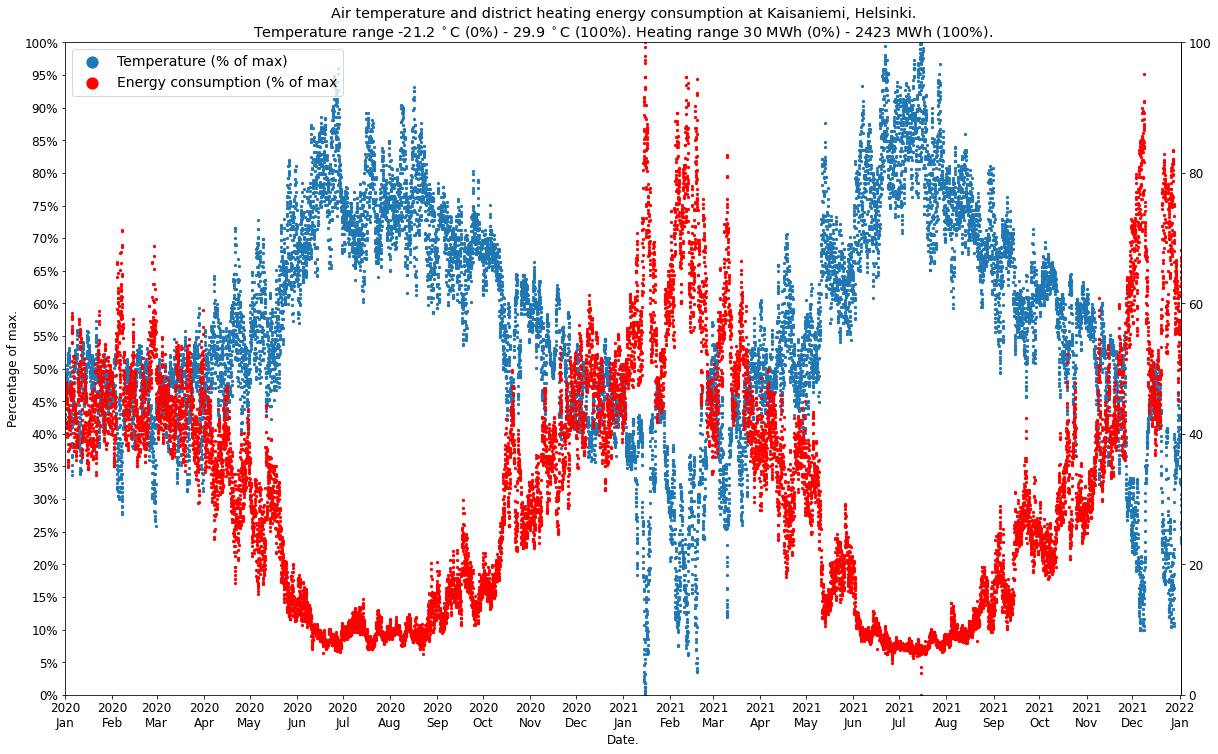

In [110]:
fig, axes = plt.subplots()

axes.set_title(f"""Air temperature and district heating energy consumption at Kaisaniemi, Helsinki.
{temperature_range_string} {heating_range_string}""")
              
axes.set_xlabel("Date.")
# Drop month to second line in an abbreviated form, instead of same line with number form.
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y\n%b'))
# Show every month.
axes.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))

axes.set_ylabel("Percentage of max.")
axes.set_yticks(np.arange(0, 105, 5))

# TODO: How to get reference to this one and set the ticks of this one separately?
#axes.secondary_yaxis(location = "right")

# Add percentage symbol to y-axis labels.
axes.yaxis.set_major_formatter(mtick.PercentFormatter())

# Turn temperatures to percentages over the range (from -something to plus something).
perc_temperature = convert_column_percentages(df_district_weather_exact.air_temperature_C)
axes.scatter(x = df_district_weather_exact.date_time, 
             y = perc_temperature, 
             s = 5, 
             label = "Temperature (% of max)")

# Turn energy consumption to percentages over the range (from 0 to ~2500).
perc_energy = convert_column_percentages(df_district_weather_exact.district_heating_MWh)
axes.scatter(x = df_district_weather_exact.date_time, 
             y = perc_energy, 
             s = 5, 
             c = "red", 
             label = "Energy consumption (% of max")

axes.legend(loc = "upper left", fontsize = 14, markerscale = 5)

#fig.savefig("HelsinkiEnergiaLampotilaTempAndHeating.png", facecolor = "white", transparent = False)

plt.show()

# Draw Temperature and energy consumption with energy consumption reversed.

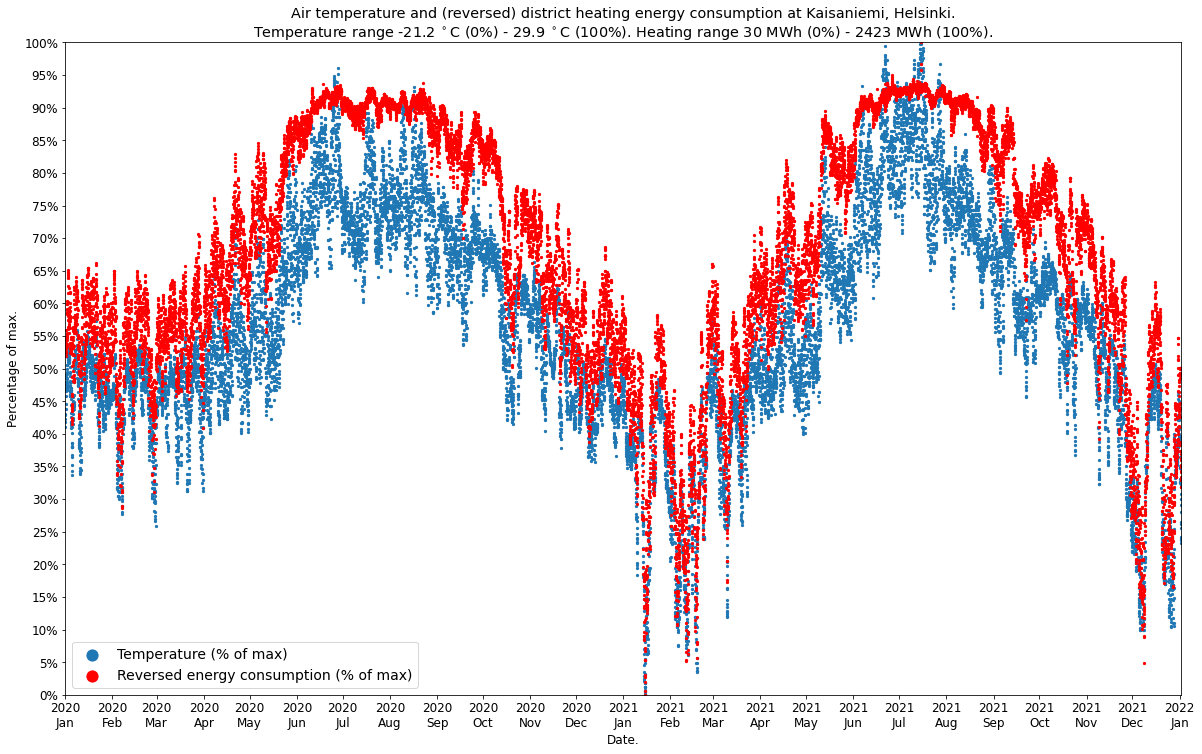

In [106]:
fig, axes = plt.subplots()

axes.set_title(f"""Air temperature and (reversed) district heating energy consumption at Kaisaniemi, Helsinki.
{temperature_range_string} {heating_range_string}""")
              
axes.set_xlabel("Date.")
# Drop month to second line in an abbreviated form, instead of same line with number form.
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y\n%b'))
# Show every month.
axes.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))

# TODO: Separate ylabels for percentage and energy consumption, as they are reversed here.
# TODO: Display the minimum, maximum and halway values of the ranges in addition to percentages.
axes.set_ylabel("Percentage of max.")
axes.set_yticks(np.arange(0, 105, 5))
# Add percentage symbol to y-axis labels.
axes.yaxis.set_major_formatter(mtick.PercentFormatter())

axes.scatter(x = df_district_weather_exact.date_time, 
             y = perc_temperature, 
             s = 5, 
             label = "Temperature (% of max)")

# Turn energy consumption to percentages over the range (from 0 to ~2500).
# Also reverse the values, so that you can see that it correlates with temperature.
perc_energy = convert_column_percentages(df_district_weather_exact.district_heating_MWh, reverse = True)
axes.scatter(x = df_district_weather_exact.date_time, 
             y = perc_energy, 
             s = 5, 
             c = "red", 
             label = "Reversed energy consumption (% of max)")

axes.legend(loc = "lower left", fontsize = 14, markerscale = 5)

#fig.savefig("HelsinkiEnergiaLampotilaTempAndHeatingReversed.png", facecolor = "white", transparent = False)

plt.show()

In [99]:
# We have to use .reshape and to use that we have to use numpy array.
xp = np.array(df_district_weather_exact.air_temperature_C).reshape(-1,1)
yp = np.array(df_district_weather_exact.district_heating_MWh).reshape(-1,1)

model = linear_model.LinearRegression() # pick regression model
model.fit(xp, yp) # fitting the model = training the model
xp, yp

(array([[-0.2],
        [ 0.2],
        [ 0.4],
        ...,
        [-9. ],
        [-9.1],
        [-9.3]]),
 array([[1164.031059],
        [1148.63612 ],
        [1121.186005],
        ...,
        [1579.049687],
        [1561.76587 ],
        [1541.078344]]))

In [100]:
# Check fitted params of the model
m = model.coef_         # m is slope, note underscore
b = model.intercept_    # b is y-intercept, note underscore!
m, b

(array([[-50.97700551]]), array([1178.79442965]))

In [101]:
# Model evaluation
yhat = model.predict(xp)

# These values depend on data itself.
print('Mean Absolute Error:', metrics.mean_absolute_error(yp, yhat))
print('Mean Squared Error:', metrics.mean_squared_error(yp, yhat))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yp, yhat)))

# This value is between 0 and 1.
print('R2 value:', metrics.r2_score(yp, yhat))

Mean Absolute Error: 97.28515693222
Mean Squared Error: 15118.582419732891
Root Mean Squared Error: 122.95764482020991
R2 value: 0.9275228449626126


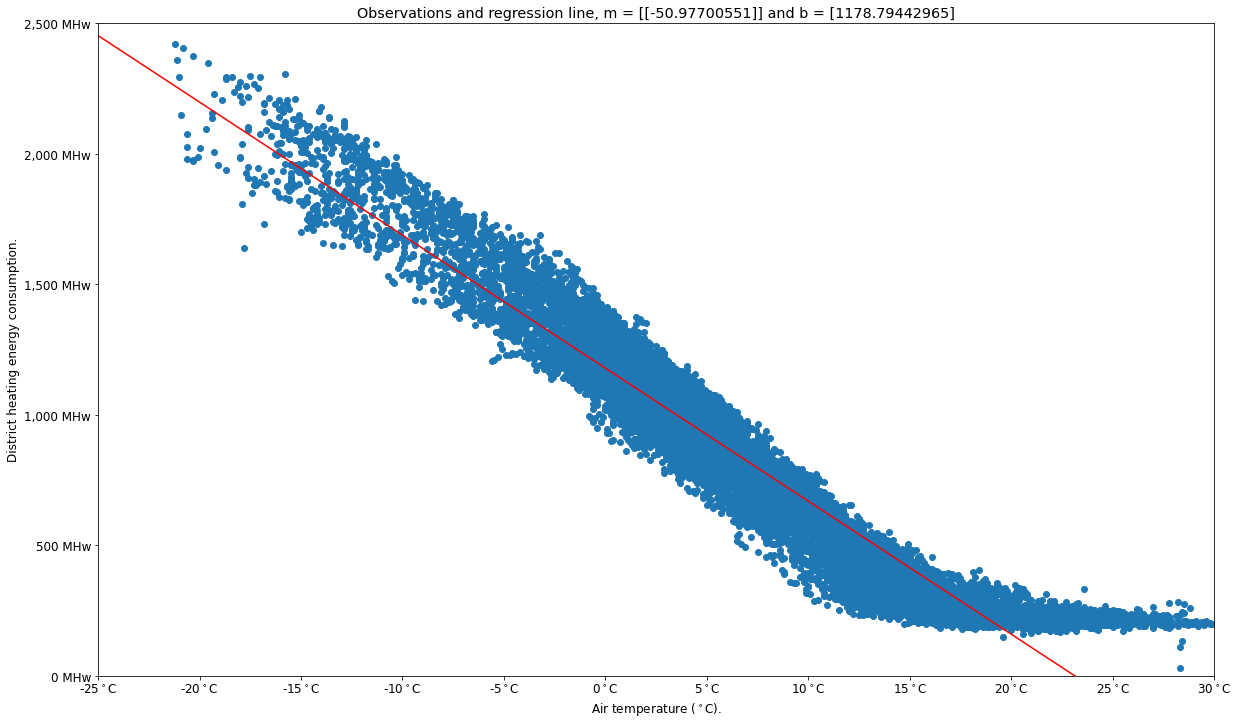

In [102]:
fig, axes = plt.subplots(1, 1)

# Plot regression line
xvals = np.linspace(min_temp, max_temp, max_temp - min_temp).reshape(-1, 1)
yvals = model.predict(xvals)

axes.set_title(f"Observations and regression line, m = {m} and b = {b}")

# Weird way to print Centigrade degree symbol.
axes.set_xlabel("Air temperature ($^\circ$C).")
plt.xlim(min_temp, max_temp)
plt.xticks(np.arange(min_temp, max_temp + 5, step = 5))
# Add degree symbol to all x-axis values.
axes.xaxis.set_major_formatter("{x}$^\circ$C")

axes.set_ylabel("District heating energy consumption.")
axes.set_ylim(0, max_consumption)
axes.yaxis.set_major_formatter("{x:,.0f} MHw")

axes.plot(xvals, yvals, c = "red")                 # this plots the line
axes.scatter(xp, yp)     # these are the training data points

plt.show()

In [103]:
# second order/degree model.
poly_reg = PolynomialFeatures(degree = 8)    
X_poly = poly_reg.fit_transform(xp)

# This part is the same as before.
pol_reg = linear_model.LinearRegression()
pol_reg.fit(X_poly, yp)

LinearRegression()

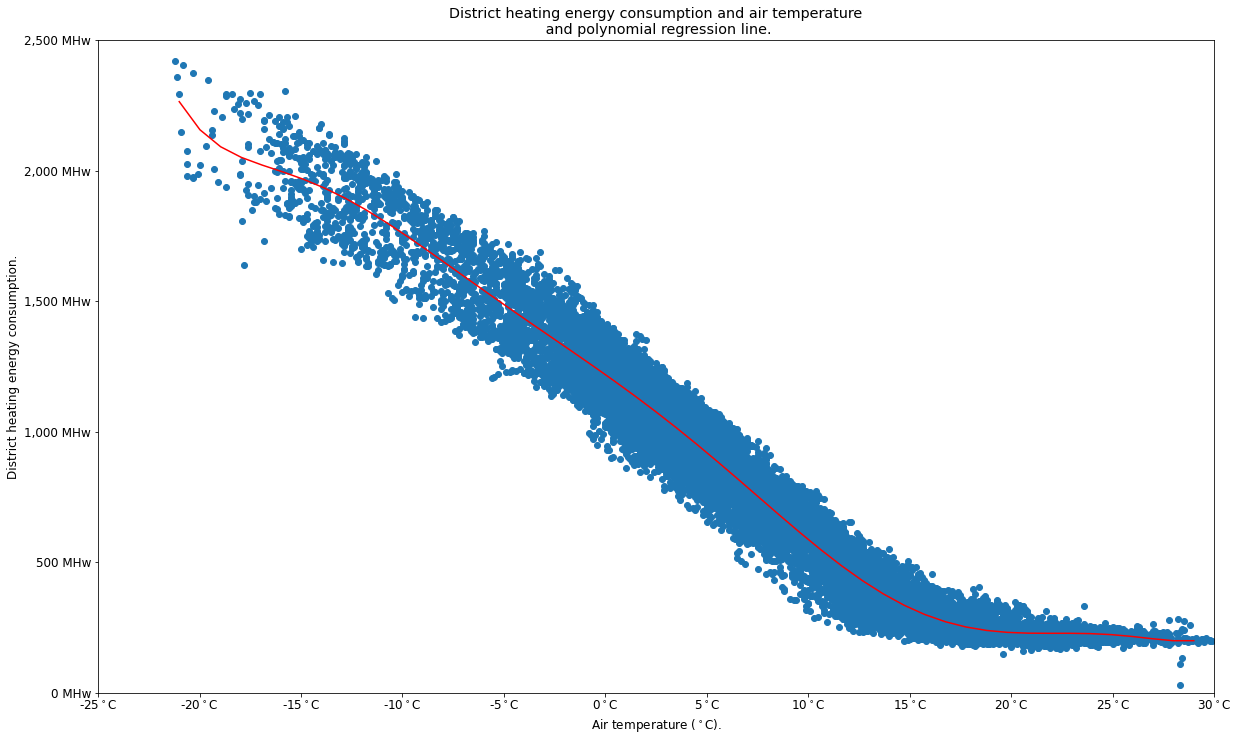

In [104]:
fig, axes = plt.subplots(1, 1)

axes.set_title("District heating energy consumption and air temperature\n and polynomial regression line.")

axes.scatter(xp, yp)
xmin = int(xp.min())
xmax = int(xp.max())
# Line needs some extra.
xvals = np.linspace(xmin, xmax, xmax - xmin).reshape(-1, 1)
yvals = pol_reg.predict(poly_reg.fit_transform(xvals))  # HOX! fit_transform pitää olla!

# Weird way to print Centigrade degree symbol.
axes.set_xlabel("Air temperature ($^\circ$C).")
axes.set_xlim(min_temp, max_temp)
axes.set_xticks(np.arange(min_temp, max_temp + 5, step = 5))
# Add degree symbol to all x-axis values.
axes.xaxis.set_major_formatter("{x}$^\circ$C")

axes.set_ylabel("District heating energy consumption.")
axes.set_ylim(0, max_consumption)
axes.yaxis.set_major_formatter("{x:,.0f} MHw")

axes.plot(xvals, yvals, c = "red")

#fig.savefig("HelsinkiEnergiaLampotilaPolynomialRegression.png", facecolor = "white", transparent = False)
plt.show()

In [105]:
yhat = pol_reg.predict(poly_reg.fit_transform(xp)) # HOX! fit_transform pitää olla!
print('R2 value:', metrics.r2_score(yp, yhat))

R2 value: 0.9626685911524222
